# DT2470 Lab 04: Shazam Wow!

**Group 6: Sergi Andreu and Carsten van de Kamp**

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

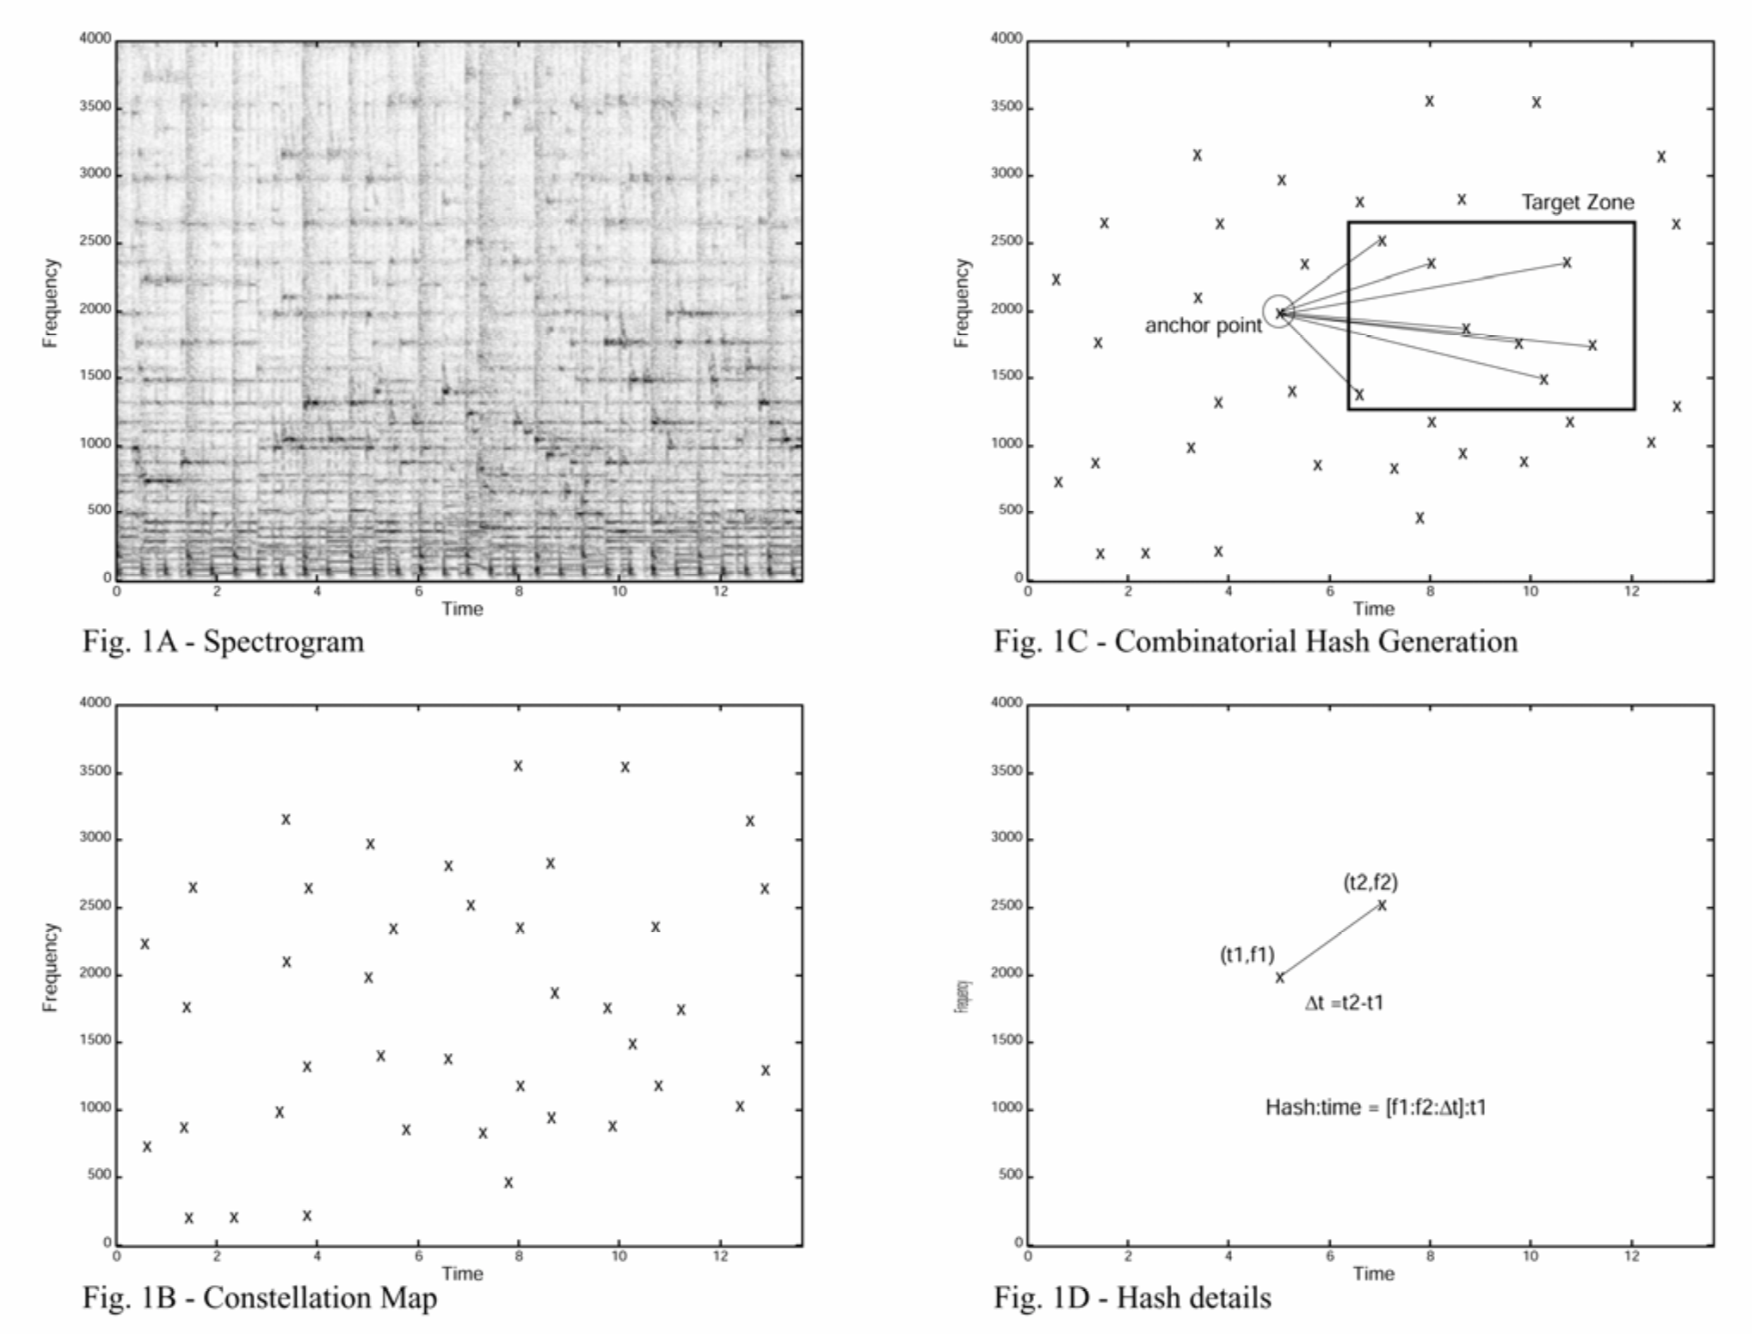

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


In [1]:
# Import general relevant packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import specific packages for processing audio signals
import pydub
from scipy.signal import stft

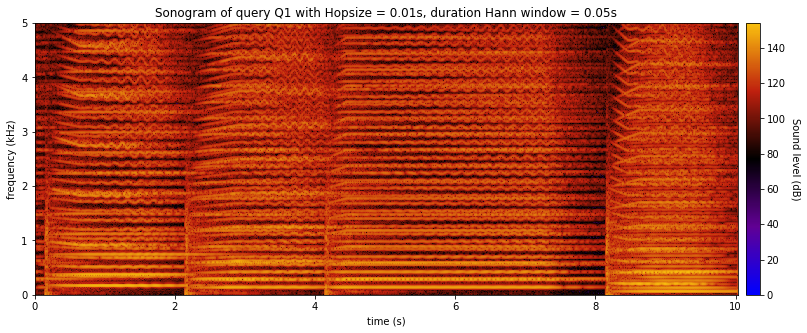

In [2]:
# add your code below

file = "Q1" #Choose between Q1, Q2, Q3, Q4, Q5 and Q6

# Parameters for STFT: 
window_time = 0.05
hop_time = 0.01

filepath = f"queries/{file}.wav"

sound = pydub.AudioSegment.from_file(filepath, format="wav")
sample_rate = sound.frame_rate
duration    = sound.duration_seconds

if sound.channels > 1:
    sound = sound.split_to_mono()[0]
samples = sound.get_array_of_samples()

window_size_in_samples = window_time * sample_rate
hop_size_in_samples    = hop_time * sample_rate

nfft = 4*window_size_in_samples # Zero padding


f, t, Zxx = stft(samples, fs=sample_rate, window='hann', 
                 nperseg=window_size_in_samples, 
                 noverlap=window_size_in_samples-hop_size_in_samples,
                 nfft=nfft, return_onesided=True)

f_kHz = f/1000  # conversion to kHz
Zxx = np.absolute(Zxx) # Zxx in the space of complex numbers,
# We are interested in the amplitude and not the phase

dB_Zxx = 20*np.log10(Zxx / np.min(Zxx)) # conversion to dB magnitude
# We use the min value of Zxx as the amplitude reference for dB


# Create custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ["blue", "#610094", "black", "#BF200E", "#F9C10E"]
cmap_halloween = LinearSegmentedColormap.from_list("mycmap", colors) 
#boOOooOoooOOOOOoo happy spooky season


#Plotting
fig, ax = plt.subplots(figsize=(15,5))                     
im = ax.pcolormesh(t, f_kHz, dB_Zxx, shading='nearest', cmap=cmap_halloween)

cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Sound level (dB)', rotation=270, labelpad=15)

ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (kHz)')
ax.set_ylim((0,5))
ax.set_xlim((0, duration))
ax.set_title(f'Sonogram of query {file} with Hopsize = {hop_time}s, duration Hann window = {window_time}s')
plt.show()

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [3]:
# add your code below

"""
scipy stft uses RFFT instead of FFT, thus directly finding the whole spectrum [0,F_s / 2].
The default argument "return_downsided=True" makes it return only one of the two slices symmetric data.

It may make sense, however, to slice the frequency values to only focus on [F_min, F_max],
where F_min, F_max are arbitrary values, specially if the algorithm is used in real applications, 
since both low and high frequencies may be easier to corrupt, they probably contain less musical information 
and they appearence may be due to noise or recording artifacts.

Although that may reduce the computing time, finding the values of F_min, F_max is arbitrary,
and thus those values should be optimized. We just set them to [0 KHz, 20 KHz] so as to not lose information.
"""


# Min and max values of the frequency (arbitrary numbers)
f_min = np.min(f_kHz)
f_max = np.max(f_kHz)

# Number of divisions of the frequency interval
N_f = 25
h_f = (f_max - f_min) / N_f
h_f_samples = len(f) / N_f

# Time step size
h_t = 0.1 # in seconds
N_t = int(duration / h_t)
h_t_samples = len(t) / N_t


points_interest = np.zeros((N_f, N_t, 2)) # Initialize the array with proper dimensions

for i in range(N_f-1):
    for j in range(N_t-1):
        
        # Select sub-rectangle of the sonogram
        M = dB_Zxx[int(i*h_f_samples):int((i+1)*h_f_samples),
                   int(j*h_t_samples):int((j+1)*h_t_samples)]
        
        # Find the relative coordinates of the maximum (given as integer indices)
        point = np.unravel_index(M.argmax(), M.shape)
        # we use unravel_index since M.argmax() returns a scalar, and we want a 2D list
        
        # Convert the relative coordinates into absolute coordinates 
        # and add them to points_interest
        points_interest[i,j] = np.array([i*h_f+f_min+(h_f/h_f_samples)*point[0] ,
                                         j*h_t+(h_t/h_t_samples)*point[1]])

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

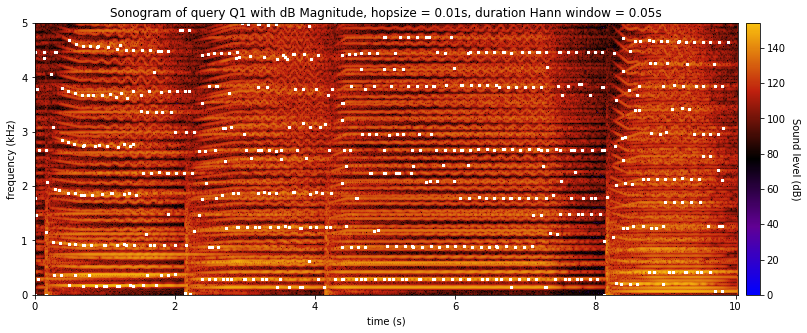

In [4]:
# Reshape the array (for plotting purposes)
# We essentially flatten the array and then transpose it
points_interest_reshaped = points_interest.reshape(N_f*N_t, 2)
points_interest_reshaped = np.transpose(points_interest_reshaped)

# Plotting
fig, ax = plt.subplots(figsize=(15,5))                     
im = ax.pcolormesh(t, f_kHz, dB_Zxx, shading='nearest', cmap=cmap_halloween)

cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Sound level (dB)', rotation=270, labelpad=15)

ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (kHz)')
ax.set_ylim((0,5))
ax.set_xlim((0, duration))
ax.scatter(points_interest_reshaped[1], points_interest_reshaped[0], 
           marker="$😱$", 
           s=5, c="white")
ax.set_title(f'Sonogram of query {file} with dB Magnitude, hopsize = {hop_time}s, duration Hann window = {window_time}s')
plt.show()

---

The anchors observed in the figure (clearly represented by little screaming faces) are by construction located at the maximum local amplitudes. 
We see that they follow most of the predominant lines in the spectrogram, which is what we intented.

The idea behind finding the anchors is to do a dimensionality-reduction of the STFT data, and the assumption behind this approach is considering that the most relevant "points" of the sonogram array are the ones in which we have higher volume intensity.\
This approach has some drawbacks: it does not seem to be robust to noise, the choice of the $\Delta t$, $\Delta f$ boxes create numerical and qualitative errors (for the later, some songs may need more / less temporal or frequency definitions to get useful fingerprints), and "the most relevant points" is an ill-posed definition, as one can find examples of useful definitions that the points with highest local amplitude do not obey.


But it is easy to implement, it works, and in this case it gives results that we qualitatively see as relevant.
Of course, the implementation could be optimized (i.e. there may be ways to parallelize computations and avoid loops, and intermediate variables could be avoided), but we prioritize readability and time.

---

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [5]:
# add your code below

# Define custom parameters for finding the fingerprints:
skip_time = 0.1
width_time = 0.5

min_ratio_f = 2**(-0.5)
max_ratio_f = 2**(0.5)


"""
We expect the skip_time and width_times to be a multiple of the time discretization in the previous step.
If not, we are in big trouble.......
(not really, but please, give skip_times and width_times that are multiple of the time step in the STFT)

((else: suffer))
"""

skip_cells_t = int(skip_time/h_t)
width_cells_t = int(width_time/h_t)

if not (skip_time / h_t).is_integer() and (width_time / h_t).is_integer():
    print("OMG PLEASE...")
    

# Initialize the array containing the hashes, and their corresponding times
TIMES = []
HASHES = []

for i in range(N_f-1):
    for j in range(N_t-1):
        
        # Select an anchor
        point = points_interest[i,j]
        f1 = point[0]
        t1 = point[1]
         
        # find min and max frequency cells to observe (given by the ratios)
        min_f_cell = int(f1*min_ratio_f/h_f)
        max_f_cell = min(int(f1*max_ratio_f/h_f), N_f-1)
        
        # get width of the cells observed (in f and t)
        width_cells_f_loc = min(max_f_cell - min_f_cell, N_f-i-1)
        width_cells_t_loc = min(width_cells_t, N_t-j-1)
        
        # Iterate through the observed cells and append the proper
        for ii in range(width_cells_f_loc):
            for jj in range(width_cells_t_loc):
                point2 = points_interest[i+ii, j+skip_cells_t+jj]
                # ii and jj are relative indices, i and j are total indices
                
                f2 = point2[0]
                t2 = point2[1]
                
                TIMES.append(t1)
                HASHES.append([f1, f2, t2-t1])

            
fp_1 = [np.array(TIMES), np.array(HASHES)] # Convert each sub-array to np.array

# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

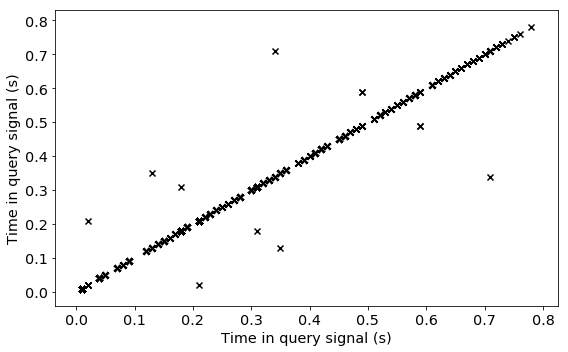



In [6]:
# add your code below

# Convert the previous way of geting a fingerprint into a function

def get_fingerprint(sound, sample_rate = None, duration = None,
                window_time = 0.05, hop_time = 0.01, nfft = 8192,
                h_f = h_f, h_t = h_t,
                skip_time = 0.1, width_time = 0.5,
                min_ratio_f = 2**(-0.5), max_ratio_f = 2**(0.5)):
    
    """
    ::sound:: audio sample. It should be in pydub format (pydub.AudioSegment.from_file)
    
    ::sample_rate:: sample rate. If None, it get it from the sound file
    ::duration:: desired duration. If None, it selects the duration of the whole file
    
    ::h_f:: frequency step width (used for getting the anchors)
    ::h_t:: time step width (used for getting the anchors)
    
    and company...
    
    """
    
    if sample_rate == None:
        sample_rate = sound.frame_rate
        
    if duration == None:
        duration    = sound.duration_seconds

    if sound.channels > 1:
        sound = sound.split_to_mono()[0]
        
    samples = sound.get_array_of_samples()[:int(duration*sample_rate)]
    
    window_size_in_samples = window_time * sample_rate
    hop_size_in_samples    = hop_time * sample_rate
    
    f, t, Zxx = stft(samples, fs=sample_rate, window='hann', 
                    nperseg=window_size_in_samples,
                    noverlap=window_size_in_samples-hop_size_in_samples,
                    nfft=nfft, return_onesided=True)
    
    Zxx = np.absolute(Zxx)
    dB_Zxx = 20*np.log10(Zxx / np.min(Zxx))
    
    f_min = np.min(f_kHz)
    f_max = np.max(f_kHz)
    
    N_f = int((f_max - f_min) / h_f)
    h_f_samples = len(f) / N_f

    N_t = int(duration / h_t)
    h_t_samples = len(t) / N_t
    
    points_interest = np.zeros((N_f, N_t, 2))

    for i in range(N_f):
        for j in range(N_t):
            M = dB_Zxx[int(i*h_f_samples):int((i+1)*h_f_samples), int(j*h_t_samples):int((j+1)*h_t_samples)]
            try:
                point = np.unravel_index(M.argmax(), M.shape)
                
                freq_index = i*h_f+f_min+(h_f/h_f_samples)*point[0]
                time_index = j*h_t+(h_t/h_t_samples)*point[1]
                
                points_interest[i,j] = np.array([freq_index , time_index])
            except:
                pass
            
    skip_cells_t = int(skip_time/h_t)
    width_cells_t = int(width_time/h_t)
    
    if not (skip_time / h_t).is_integer() and (width_time / h_t).is_integer():
        print("you are an awful person.")

    TIMES = []
    HASHES = []

    for i in range(N_f-1):
        for j in range(N_t-1):
            point = points_interest[i,j]
            f1 = point[0]
            t1 = point[1]

            min_f_cell = int(f1*min_ratio_f/h_f)
            max_f_cell = min(int(f1*max_ratio_f/h_f), N_f-1)

            width_cells_f = min(max_f_cell - min_f_cell, N_f-i-1)
            width_cells_t = min(width_cells_t, N_t-j-1)

            for ii in range(width_cells_f):
                for jj in range(width_cells_t):
                    point2 = points_interest[i+ii, j+skip_cells_t+jj]

                    f2 = point2[0]
                    t2 = point2[1]
                    
                    TIMES.append(t1)
                    HASHES.append([f1, f2, t2-t1])
                    
    return [np.array(TIMES), np.array(HASHES)]

In [7]:
# add your code below

# define a function that get matching times from two different fingerprints of hashes

def find_matching_times(fp_1, fp_2, threshold=0.00):
    
    """
    ::fp_1:: fingerprint 1. Collection of hashes of the form [TIMES, HASHES]
    ::fp_2:: fingerprint 2. Collection of hashes of the form [TIMES, HASHES]
    
    ::threshold:: Maximum distance allowed for identifying two different hashes as a match.
                  Since we do not have noise in this test case, a threshold=0.00 is sufficient.
                  However, if we add noise, or even if we slice the audio sample, we may need
                  a nonzero threshold value.
    """
    
    # Unwrap the fingerprints
    times_1 = fp_1[0]
    hashes_1 = fp_1[1]
    times_2 = fp_2[0]
    hashes_2 = fp_2[1]
    
    
    # Initialize the arrays containing the matching times
    matching_times_1 = np.array([])
    matching_times_2 = np.array([])

    # Number of hashes of the different samples
    N_hashes_1 = np.shape(hashes_1)[0]
    N_hashes_2 = np.shape(hashes_2)[0]
    
    
    # Iterate through one of the hashes, keeping the other constant
    # (we are, kind of, implementing a convolution)
    # this avoids having to use two loops
    for i in range(N_hashes_2):

        current_hash = hashes_2[i]
        vector_hash = np.tile(current_hash, (N_hashes_1, 1))
        # vector_hash is a copy of the current hash along the second dimension

        difference = np.absolute(vector_hash - hashes_1)
        # difference is now a comparison of our current hash of sample 2
        # with all the hashes of sample 1
        # It has a list [dif1, dif2, dif3] for each hash of sample 1
        # (dif1 = |a-d|, dif2 = |b-e|, dif3 = |c-f|)
        
        difference = np.sum(difference, axis=1)
        # sum the difference along axis 1. 
        # Basically, sum the three absolute differences
        # d = dif1 + dif2 + dif3
    
        # Return the indices where the difference is smaller than the threshold
        # (we have a similarity there)
        bool_difference = difference <= threshold
        idx = np.argwhere(bool_difference).squeeze()
        
        # In case we only have a similarity, append. Otherwise, concatenate.
        # (a better coding approach may be possible)
        n_similar = idx.size
        
        if n_similar == 1 : 
            matching_times_1 = np.append(matching_times_1, np.array(times_1[idx]))
            matching_times_2 = np.append(matching_times_2, np.array(times_2[i]))
            
        elif n_similar > 1:
            matching_times_1 = np.concatenate((matching_times_1, np.array([times_1[ii] for ii in idx])))
            matching_times_2 = np.concatenate((matching_times_2, np.tile(times_2[i], n_similar)))
    
    return matching_times_1, matching_times_2

In [8]:
# define a plot function

def plot_scatter_times(t_1,t_2,
                style="custom", restrict_to_min_duration=False,
                equal_aspect=True):
    
    if style=="custom": plt.style.use('standard.mplstyle')

    if restrict_to_min_duration: figsize = (5,5)
    else: figsize = (5*(np.max(t_1)/np.max(t_2)),5)

    fig, ax = plt.subplots(figsize=figsize)                     
    ax.set_xlabel('Time in signal 1 (s)')
    ax.set_ylabel('Time in signal 2 (s)')

    if equal_aspect: ax.set_aspect("equal")
    ax.set_title(f'Hash similarity between two signals')

    ax.scatter(t_1, t_2, marker=r"$\dagger$", c="k", s=50)

    if restrict_to_min_duration:
        min_duration = min(np.max(t_1), np.max(t_2))
        ax.set_xlim(0,min_duration)
        ax.set_ylim(0,min_duration)

    plt.show()
    
    if style=="custom": mpl.rcParams.update(mpl.rcParamsDefault)
    

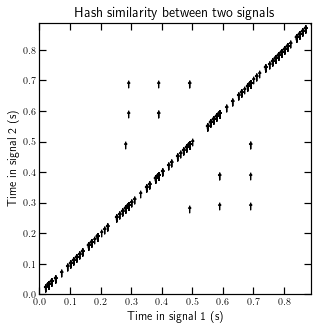

In [9]:
query_file = "Q2"
query_filepath = f"queries/{query_file}.wav"

query_sound = pydub.AudioSegment.from_file(query_filepath, format="wav")
fp_Q = get_fingerprint(query_sound, duration=1)    # 1s query duration

t1_Q , t2_Q = find_matching_times(fp_Q, fp_Q, threshold=0.01)
assert t1_Q.any() == t2_Q.any()
plot_scatter_times(t1_Q, t2_Q, restrict_to_min_duration=True)

Since we compare the signal with itself we expect to see every hash appear on the diagonal (every hash is identical to itself). Moreover the scatterplot should be symmetric in the diagonal.  

The off-diagonal entries correspond to coincidential similarities between different hashes. For example due to recurring patterns in the sound file.

----

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

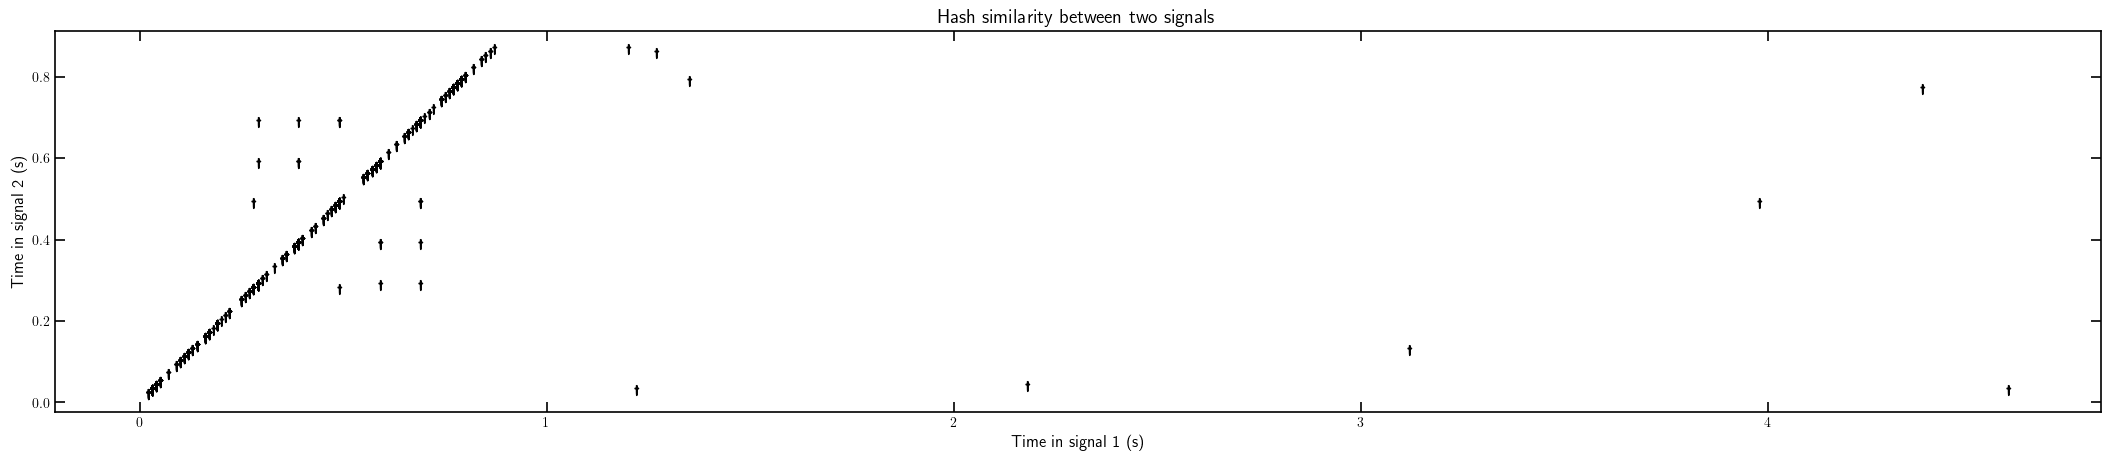

In [10]:
# add your code below

fp_Q_full = get_fingerprint(query_sound, duration=5) #duration shorter for visualization purposes
t_Q_full , t_Q = find_matching_times(fp_Q_full, fp_Q, threshold=0.01)

plot_scatter_times(t_Q_full, t_Q)

Here we have the document signal on the x-axis and the query signal on the y axis. We see again a nice similarity between the hashes in the query and the first second of the document (which in this case is the query signal). All detected similarities after $t=1$s in the document signal are coincidential similarities between two hashes. Again for instance because of recurring patterns in the audio.

Hence, for two unkown signals, whenever the hash similarity scatter plot contains a diagonal line (perfect diagonal with equally scaled axes!) then there is a high probability the signals are the same. The diagonal line occurs exactly at the times between the query and the document signal are similar.

-----------------

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

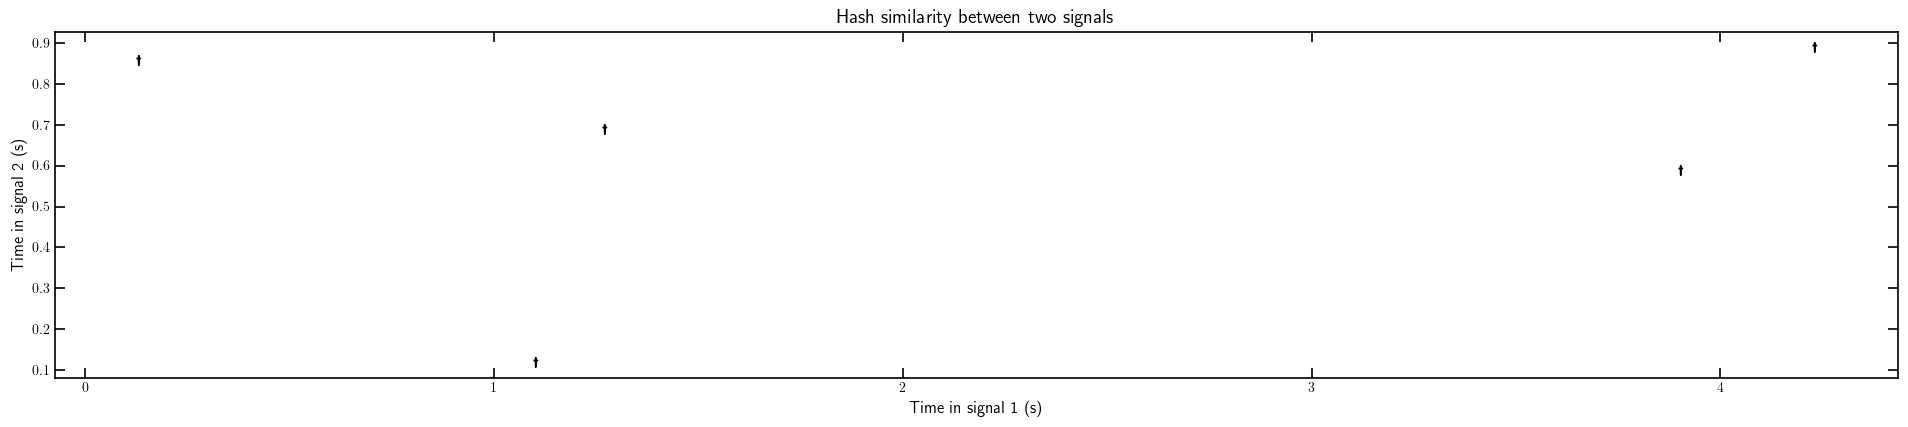

In [11]:
# add your code below

document_file = "Q5" #Choose between Q1, Q2, Q3, Q4, Q5 and Q6
document_filepath = f"queries/{document_file}.wav"
document_sound = pydub.AudioSegment.from_file(document_filepath, format="wav")

fp_D = get_fingerprint(document_sound, duration=5)  #duration shorter for visualization purposes
t_D , t_Q = find_matching_times(fp_D, fp_Q, threshold=0.01)

plot_scatter_times(t_D, t_Q)

Now the plot is very different from what we saw above! There are very few hash similarities detected and we do not see a diagonal structure anymore. Hence we can conclude that the signals are different and the query is therefore not a part of the document signal.

The few similiarities occur due to coincidential similiarites in the signal.

-----------

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.

---

We fortunately have a project idea. However, we observe two main drawbacks of our code before for real-life or Kiki-Bouba applications: possible noise or corrupted fingerprints (for example, slicing the audio signals differently) and efficient synchronization between the query and the audio samples in Kiki-Bouba.

### Robustness to noise

Solving the noise problem is not easy. Having a better selecion of the fingerprints that is robust to noise and that is easy to implement is a hard problem. However, adding a nonzero-threshold (that we have already implemented in our code) seems to give good results, even with noise (we tried it in the code above).

Thus maintaining our fingerprints is an option, but a more efficient (parallelized) algorithm is needed, since deadlines exist.

### General robustness

If we do not focus on white noise, but rather on "designed" noise, it is easy to manipulate our algorithm. Anyone with the same audio sample as us could compute the local maximum amplitudes of the spectrogram, and just change the amplitude at those specific points. Our algorithm would in that case fail if we used the same parameters.

Moreover, changing the speed of our sample, or changing the pitch slightly, would also fail. The hashes are invariant to time (since we look at time differences (t2-t1)), but not to scaling of the frequencies or speed.

This approach is not intended for song identification with "legal" intentions, but rather the song samples are assumed to be non-corrupted by the user, at least intentionally. 
</br>

### Synchronization

We would also have to synchronize the queries with the audios. In this lab we only explored the option of having both audio samples starting at the same time. However, this is not the case in applications.

Finding that the query coincide with an audio sample is equivalent to finding a "straight-line" pattern in the scatter plot of mathing times.
Considering that the speed of both audio signals is the same, we aim at finding a straight line with slope 1 that best describes the matching times at a given region.

Supposing that the audio sample is not repeated (in that case, we may just slice the audio sample), we want to model the matching times of sample 2 as:

$$y(t_1) = A + t_1 $$

where $A=a \cdot 1$, and $a$ is the point at which synchronization starts (the notation is such that $1$ is a vector of ones with the same dimension as $t_1$), and $t_1$ the matching times of the audio sample 1.

The problem is equivalent to solving the least-squares problem, where $y(t_1)$ has to model $t_2$.
We can define a new vector $\tau = t_2 - t_1$

$$\tau = t_2 - t_1 = A$$

The least-squares problem can be thus formulated as:

Find the parameter $a$ such that the residual $r = \tau - A$ is minimized in the $L_2$ sense.

Although there may be a more straightforward approach, this is quite an intuitive one: the solution of the Least Squares Method would return the value $a$, i.e. the time at which synchronization starts, and the residual $r$ would contain information about the error that we are doing by supposing that the query is part of the other audio sample.

Since we would have more matching times in case the query is actually part of the audio sample, the error should be "normalized" with respect to the total number of matching times (length of $r$). An example could be:

$$error = \frac{\| r \|_2}{  len(r)} $$

Where $error$ is a variable that would be $0$ when we have a "perfect matching": the matching times can be perfectly described by a straight line of slope $1$, starting at time $a$.
It however can be "arbitrarily" large (not really, but we are lazy on this).

From this $error$ it should be possible to infer a score, such that a score 1 means that we are perfectly sure that the query matches the audio, and a score of 0 means that we are sure it does not match.
If we had the maximum $error$, $score = 1 - (error / MaxError)$ may be a good measure. In this case, however, the distribution of the error seems rather complex, and probably one should use something like $log(error)$, and derive the possible distribution of error values by using some statistics.

We have a general least squares closed-form solution for this kind of problems, but due to the dimensionality of our example it is best to derive the minimization solution here. We can directly pose the problem as the one minimizing the residual.

The L2 norm of the residual would be given by

$$\| r \|_2 = \sum_{i=1}^{N} (\tau_i - a)^2 $$

Since this is a convex problem, it is enough to look at the $a$ such that its partial derivative with respect to $a$ is $0$,

$$\sum_{i=1}^{N} -2(\tau_i - a) \implies a = \frac{1}{N} \sum_{i=1}^{N} \tau = \langle \tau \rangle$$

We thus only need to look at the mean of $t_2 - t_1$. And once we have that, the residual would be given by

$$\| r \|_2 = \sum_{i=1}^{N} (\tau_i - \langle \tau \rangle)^2 $$

$$\| r \|_2 = \text{Var}(\tau) $$

(nice)

---

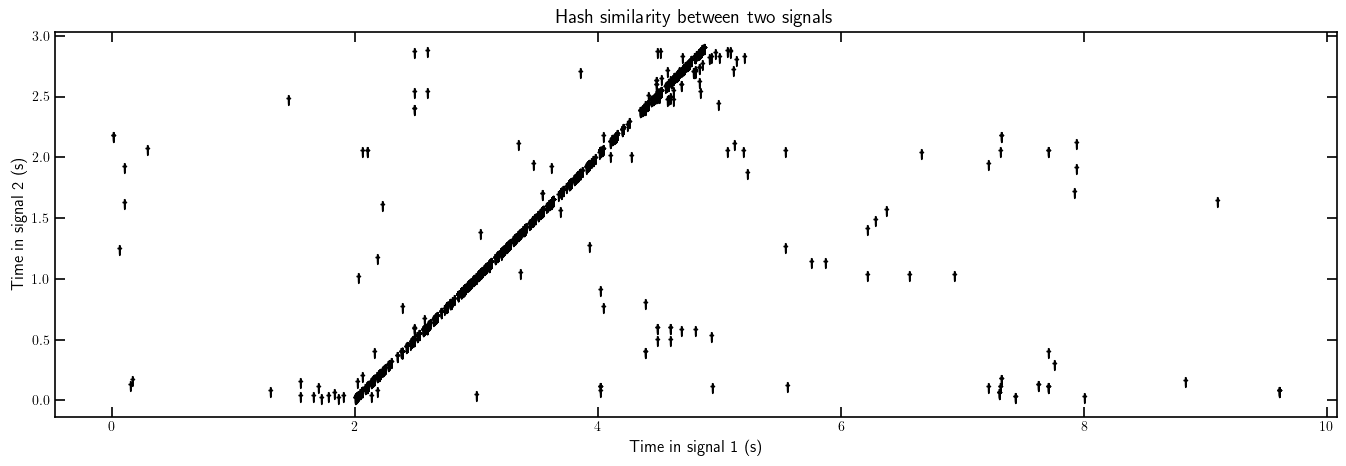

In [12]:
from pydub.generators import WhiteNoise

file_1 = "Q1"
file_2 = "Q1"

filepath_1 = f"queries/{file_1}.wav"
filepath_2 = f"queries/{file_2}.wav"

sound_1 = pydub.AudioSegment.from_file(filepath_1)
if sound_1.channels > 1:
        sound_1 = sound_1.split_to_mono()[0]
        
slice_sound_1 = True
slice_a = 2000
slice_b = 5000

if slice_sound_1:
    sound_1 = sound_1[slice_a : slice_b]
        
sound_2 = pydub.AudioSegment.from_file(filepath_2)
if sound_2.channels > 1:
        sound_2 = sound_2.split_to_mono()[0]

add_noise = False
noise_level = 15 # Change of the noise in dB. 
# Values between 10 and 15 are nice
# if you don't trust us, just listen...

if add_noise:
    noise = WhiteNoise().to_audio_segment(duration=len(sound_2))
    combined = sound_2.overlay(noise-noise_level)

    sound_2 = combined # Combine sound and noise

    
fp_2 = get_fingerprint(sound_1, duration=None)
fp_1 = get_fingerprint(sound_2, duration=None)

t_1 , t_2 = find_matching_times(fp_1, fp_2, threshold=0.01)

plot_scatter_times(t_1, t_2)

In [13]:
import IPython.display as ipd

ipd.Audio(sound_1.get_array_of_samples(), rate=sound_1.frame_rate)

In [14]:
ipd.Audio(sound_2.get_array_of_samples(), rate=sound_2.frame_rate)

In [15]:
tau = t_2 - t_1

a = np.mean(tau)
r = np.var(tau)

print("Start of synchronization: a = ", -a, 's')
print("Residual: r = ", r)

Start of synchronization: a =  2.096466644461937 s
Residual: r =  0.688742029300551


In [16]:
tau = t_2 - t_1

a = np.mean(tau)
r = np.var(tau)

duration_2 = sound_2.duration_seconds


for i in range(10):
    
    boolean_1 = t_1 < 2*(a+duration_2/2)
    boolean_2 = t_1 > 0.5*(a-duration_2/2)
    
    boolean = np.logical_and(boolean_1, boolean_2)
    
    idx = np.where(boolean)
    a = np.mean(tau[idx])

r = np.sum(np.power(tau-a, 2))
error = r / len(tau)

print(f"Start of synchronization: a = {-a} s")
print(f"Error = {error}")

Start of synchronization: a = 1.9899373455391773 s
Error = 0.7000905208295258


---
Extra note: Fortunately, the query audio files seem to be already aligned with the chosen style of this Lab.